In [81]:
#standard libraries
import pandas as pd
import numpy as np
import tensorflow as tf

#visualization
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import seaborn as sns

#other scripts
from functions import WindowGenerator
from functions import dataToTimeSeries

#pre-processing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#ML models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#DL models
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#ARIMA
from statsmodels.tsa.stattools import adfuller


# Import and merge data

## Pop tags (sensor value)

In [82]:
tags_df = pd.read_csv('./dataframes/test_tag_years.csv')
tags_df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
0,2020-01-01 20:16:23.000,-65.610535,-1.247833,-0.813797
1,2020-01-01 20:16:30.000,-65.755203,-0.904221,-0.904221
2,2020-01-01 20:16:40.000,-65.646698,-0.940399,-0.886139
3,2020-01-01 20:16:46.987,NaN,-0.922318,NaN
4,2020-01-01 20:16:50.000,-65.592453,NaN,-0.723373


In [87]:
transform=dataToTimeSeries(tags_df)
tags_df_transformed = transform.transform_round_and_fill(method='ffill')

In [88]:
tags_df_resampled = tags_df_transformed.resample('1T', on='DateTime').mean()
tags_df_resampled.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
DateTime,,,
2020-01-01 20:16:00,-65.650317,-0.987418,-0.842734
2020-01-01 20:17:00,-65.669952,-0.989482,-0.806054
2020-01-01 20:18:00,-65.783628,-0.971396,-0.821555
2020-01-01 20:19:00,-65.594260,-0.963901,-0.886142
2020-01-01 20:20:00,-65.597874,-0.989221,-0.895180


In [5]:
# sensor_data = tags_df_resampled[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values

# sensor_fft = np.fft.fft(sensor_data, axis=0)

# f1 = 0.01
# f2 = 10000


# sensor_fft_filtered = np.copy(sensor_fft)
# sensor_fft_filtered[(np.abs(np.fft.fftfreq(sensor_data.shape[0])) < f1) | (np.abs(np.fft.fftfreq(sensor_data.shape[0])) > f2)] = np.nan


# sensor_data_filtered = np.fft.ifft(sensor_fft_filtered, axis=0).real


# data_filtered = pd.DataFrame(sensor_data_filtered, columns=tags_df_resampled.columns[1:])
# data_filtered.index = tags_df_resampled.index.values

## Downtimes

In [6]:
downtime_df = pd.read_csv('all_downtimes_processed.csv')
downtime_df.head()

,DateTime,trigger,downtime
0,2020-01-06 10:00:00,1.0,1
1,2020-01-06 10:01:00,0.0,1
2,2020-01-06 10:02:00,0.0,1
3,2020-01-06 10:03:00,0.0,1
4,2020-01-06 10:04:00,0.0,1


In [7]:
downtime_df['DateTime'] = pd.to_datetime(downtime_df['DateTime'])
downtime_df.set_index('DateTime', inplace=True)

## Merge

In [8]:
df = tags_df_resampled.merge(downtime_df, left_index= True, right_index= True, how="left")
df.fillna(0, inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger,downtime
DateTime,,,,,
2020-01-01 20:16:00,-65.650317,-0.987418,-0.842734,0.0,0.0
2020-01-01 20:17:00,-65.669952,-0.989482,-0.806054,0.0,0.0
2020-01-01 20:18:00,-65.783628,-0.971396,-0.821555,0.0,0.0
2020-01-01 20:19:00,-65.594260,-0.963901,-0.886142,0.0,0.0
2020-01-01 20:20:00,-65.597874,-0.989221,-0.895180,0.0,0.0


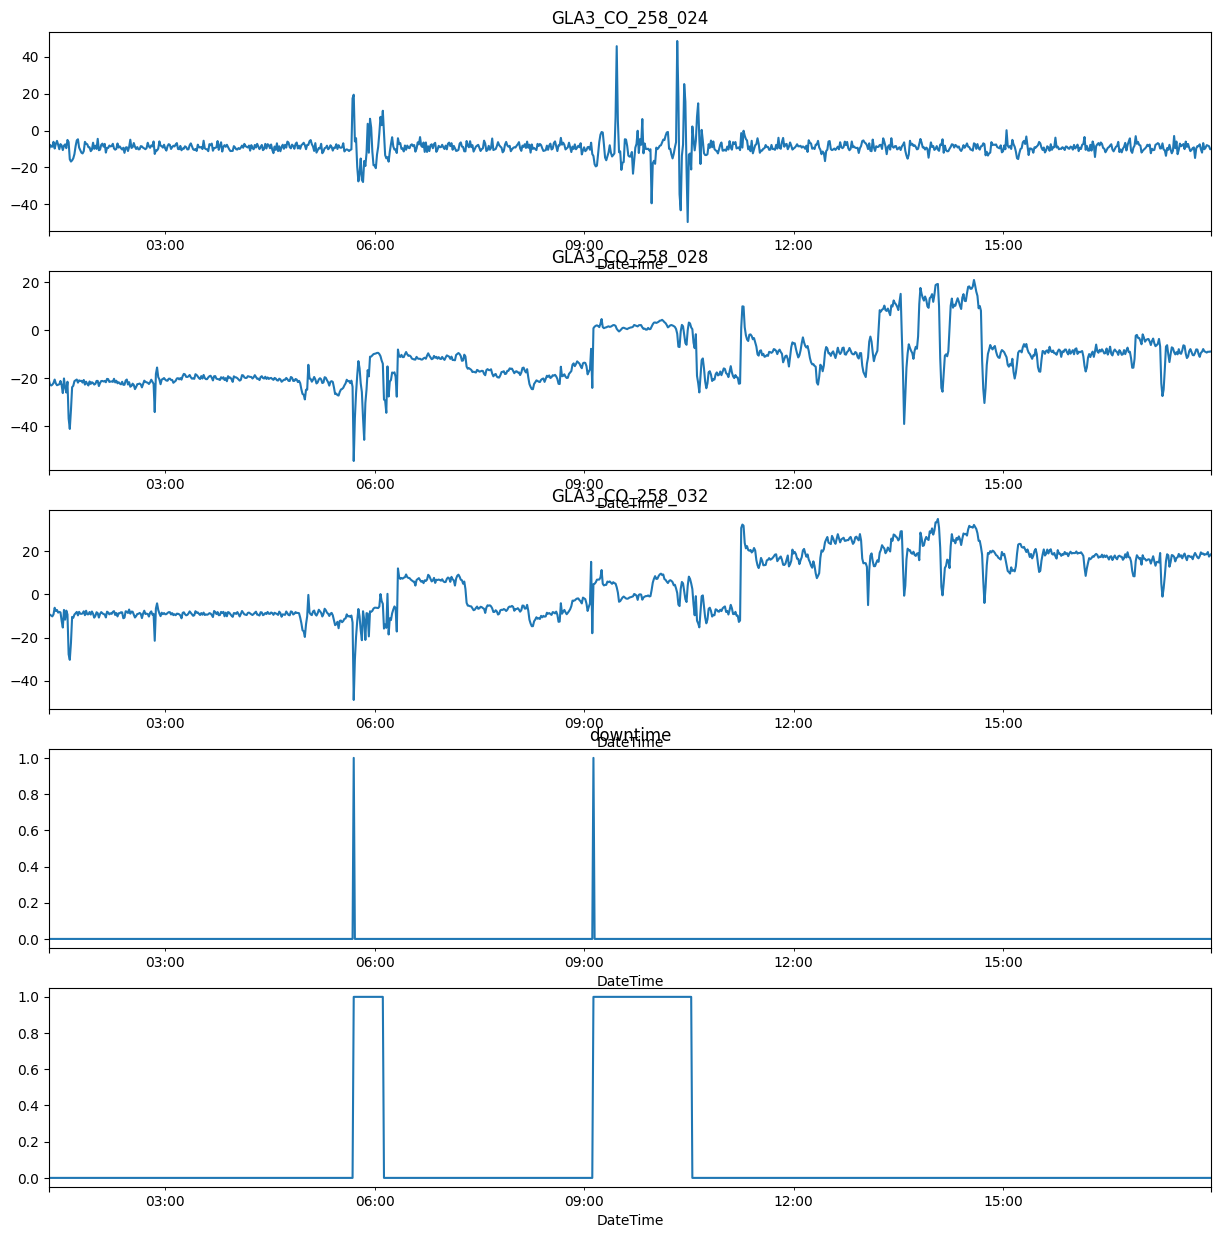

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))


df[df.index.year == 2022]['GLA3_CO_258_024'][26000:27000].plot(ax=ax1)
df[df.index.year == 2022]['GLA3_CO_258_028'][26000:27000].plot(ax=ax2)
df[df.index.year == 2022]['GLA3_CO_258_032'][26000:27000].plot(ax=ax3)
df[df.index.year == 2022]['trigger'][26000:27000].plot(ax=ax4)
df[df.index.year == 2022]['downtime'][26000:27000].plot(ax=ax5)

ax1.set_title('GLA3_CO_258_024')
ax2.set_title('GLA3_CO_258_028')
ax3.set_title('GLA3_CO_258_032')
ax4.set_title('trigger')
ax4.set_title('downtime')

plt.show()

## Visual inspection

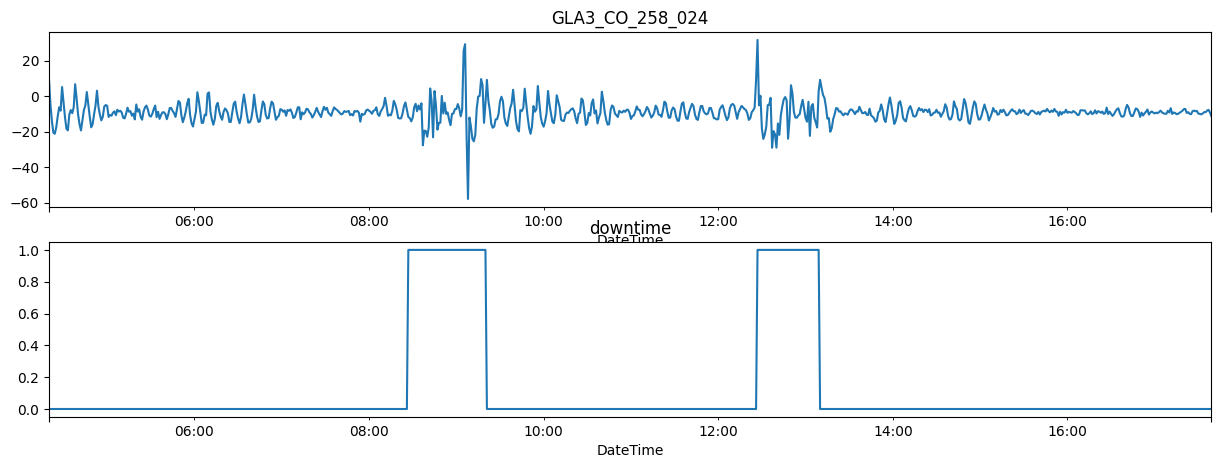

In [109]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))


df[df.index.year == 2022]['GLA3_CO_258_024'][37700:38500].plot(ax=ax1)
df[df.index.year == 2022]['downtime'][37700:38500].plot(ax=ax2)

ax1.set_title('GLA3_CO_258_024')
ax2.set_title('downtime')

plt.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [15/May/2023 09:44:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2023 09:44:42] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [15/May/2023 09:44:42] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


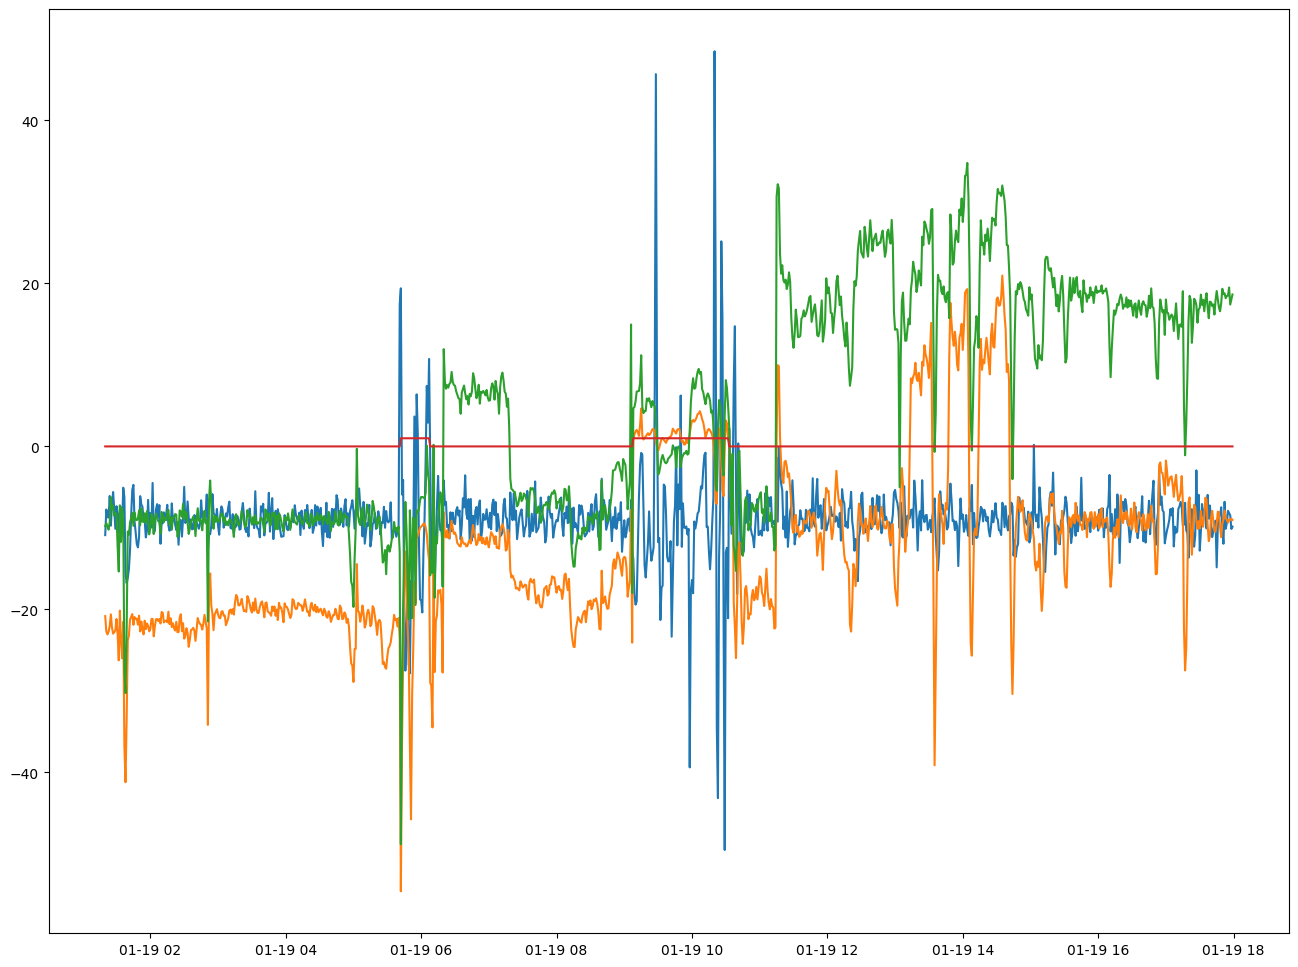

In [10]:
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(df[df.index.year == 2022]['GLA3_CO_258_024'][26000:27000])
ax.plot(df[df.index.year == 2022]['GLA3_CO_258_028'][26000:27000])
ax.plot(df[df.index.year == 2022]['GLA3_CO_258_032'][26000:27000])
ax.plot(df[df.index.year == 2022]['downtime'][26000:27000])

plugins.connect(fig, plugins.Zoom())

mpld3.show()




## Pre-processing

In [11]:
numerical_features = df.iloc[:,0:3].columns.tolist()
categorical_features = df.iloc[:,3:].columns.tolist()

In [12]:
data = df.copy()

In [13]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(data[col])

In [14]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger,downtime
DateTime,,,,,
2020-01-01 20:16:00,-1.379979,0.957810,0.214982,0,0
2020-01-01 20:17:00,-1.380610,0.957678,0.217594,0,0
2020-01-01 20:18:00,-1.384261,0.958835,0.216490,0,0
2020-01-01 20:19:00,-1.378179,0.959315,0.211890,0,0
2020-01-01 20:20:00,-1.378295,0.957694,0.211246,0,0
...,...,...,...,...,...
2023-01-03 08:29:00,0.664086,0.970661,-0.026599,0,1
2023-01-03 08:30:00,0.664119,0.969556,-0.023399,0,1
2023-01-03 08:31:00,0.663723,0.966030,-0.021554,0,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1580418 entries, 2020-01-01 20:16:00 to 2023-01-03 08:33:00
Freq: T
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   GLA3_CO_258_024  1580418 non-null  float64
 1   GLA3_CO_258_028  1580418 non-null  float64
 2   GLA3_CO_258_032  1580418 non-null  float64
 3   trigger          1580418 non-null  int64  
 4   downtime         1580418 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 104.6 MB


# Machine Learning classification

In [50]:
data.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger,downtime
DateTime,,,,,
2020-01-01 20:16:00,-1.379979,0.957810,0.214982,0,0
2020-01-01 20:17:00,-1.380610,0.957678,0.217594,0,0
2020-01-01 20:18:00,-1.384261,0.958835,0.216490,0,0
2020-01-01 20:19:00,-1.378179,0.959315,0.211890,0,0
2020-01-01 20:20:00,-1.378295,0.957694,0.211246,0,0


In [77]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['downtime'].values

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [111]:
smote = SMOTE(random_state=42)
X_underesampled, y_underesampled = smote.fit_resample(X_train, y_train)

In [112]:
rus = RandomUnderSampler(random_state=0)
X_overesampled, y_overesampled = rus.fit_resample(X_train, y_train)

In [118]:
imbalance_split = [['no_sample', X_train, y_train],
                    ['undersample', X_underesampled, y_underesampled], 
                    ['over_sample', X_overesampled, y_overesampled]]

In [130]:
def trainingModel(model, imbalance, X_train, y_train, title):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(title, ' + ', imbalance)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred, target_names=['No downtime','downtime']))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [131]:
model_generator = (model for model in [LogisticRegression(class_weight='balanced'), 
                                       DecisionTreeClassifier(class_weight='balanced'), 
                                       RandomForestClassifier()])


LogisticRegression  +  no_sample
Accuracy: 0.9080160126211176
              precision    recall  f1-score   support

 No downtime       0.94      0.92      0.93    327618
    downtime       0.84      0.88      0.85    146508

    accuracy                           0.91    474126
   macro avg       0.89      0.90      0.89    474126
weighted avg       0.91      0.91      0.91    474126



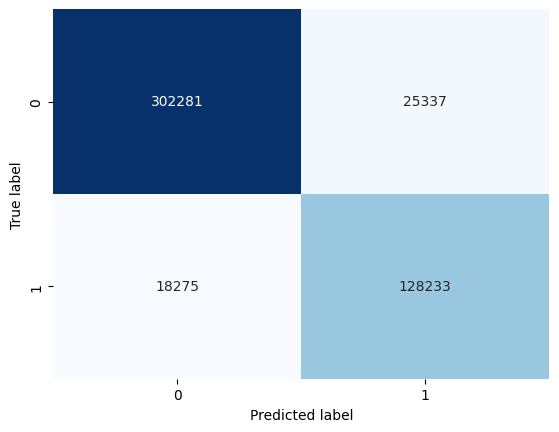

LogisticRegression  +  undersample
Accuracy: 0.9080371040609458
              precision    recall  f1-score   support

 No downtime       0.94      0.92      0.93    327618
    downtime       0.83      0.88      0.85    146508

    accuracy                           0.91    474126
   macro avg       0.89      0.90      0.89    474126
weighted avg       0.91      0.91      0.91    474126



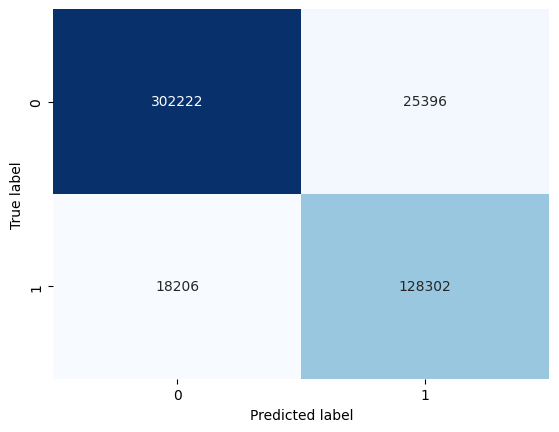

LogisticRegression  +  over_sample
Accuracy: 0.9079000097020623
              precision    recall  f1-score   support

 No downtime       0.94      0.92      0.93    327618
    downtime       0.84      0.87      0.85    146508

    accuracy                           0.91    474126
   macro avg       0.89      0.90      0.89    474126
weighted avg       0.91      0.91      0.91    474126



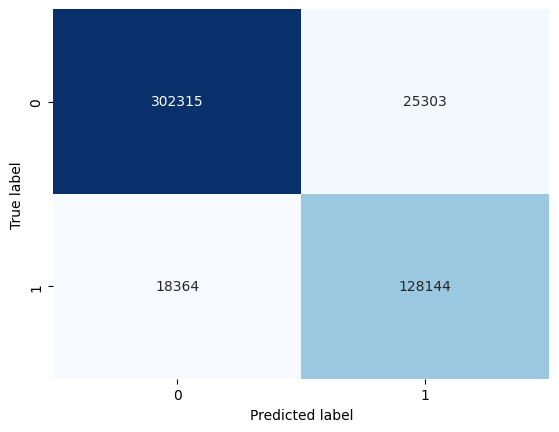

DecisionTreeClassifier  +  no_sample
Accuracy: 0.9534090094194371
              precision    recall  f1-score   support

 No downtime       0.97      0.97      0.97    327618
    downtime       0.93      0.92      0.92    146508

    accuracy                           0.95    474126
   macro avg       0.95      0.95      0.95    474126
weighted avg       0.95      0.95      0.95    474126



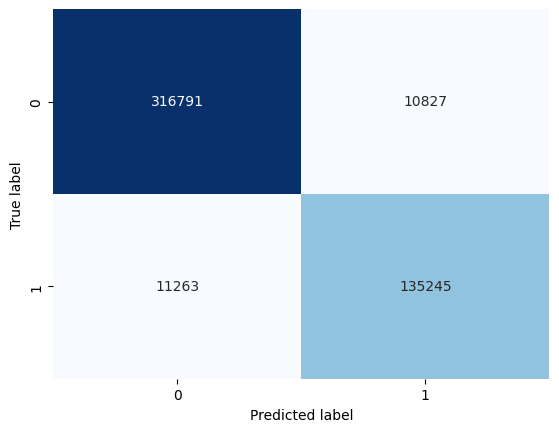

DecisionTreeClassifier  +  undersample
Accuracy: 0.9490367539430447
              precision    recall  f1-score   support

 No downtime       0.97      0.96      0.96    327618
    downtime       0.90      0.93      0.92    146508

    accuracy                           0.95    474126
   macro avg       0.94      0.94      0.94    474126
weighted avg       0.95      0.95      0.95    474126



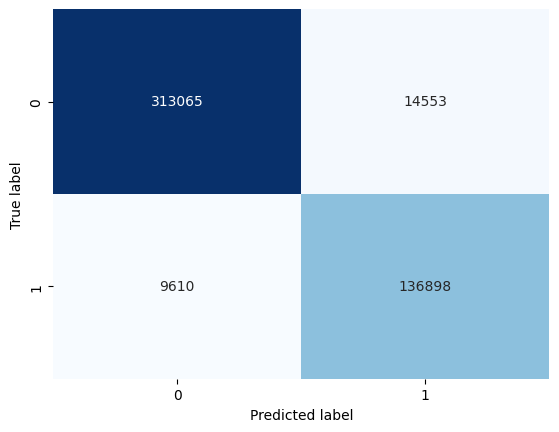

DecisionTreeClassifier  +  over_sample
Accuracy: 0.9437364751142101
              precision    recall  f1-score   support

 No downtime       0.97      0.94      0.96    327618
    downtime       0.88      0.94      0.91    146508

    accuracy                           0.94    474126
   macro avg       0.93      0.94      0.94    474126
weighted avg       0.95      0.94      0.94    474126



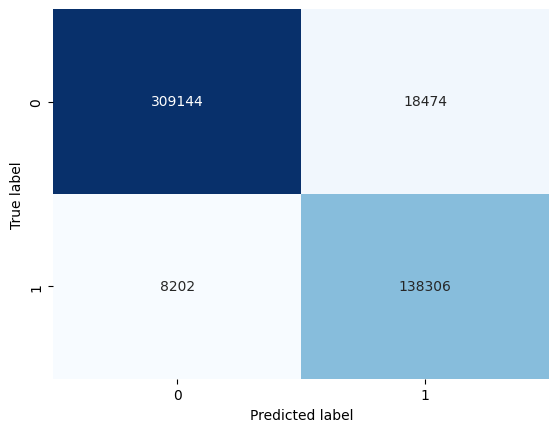

KeyboardInterrupt: 

In [132]:
for model in model_generator:
    for i in imbalance_split:
        trainingModel(model, i[0], i[1], i[2], model.__class__.__name__)

# Deep Learning Time series forecasting

In [16]:
data_bck = data.copy()

In [17]:
data.drop(columns=['trigger', 'downtime'], inplace=True)

In [18]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

In [19]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
DateTime,,,
2020-01-01 20:16:00,-1.379979,0.957810,0.214982
2020-01-01 20:17:00,-1.380610,0.957678,0.217594
2020-01-01 20:18:00,-1.384261,0.958835,0.216490
2020-01-01 20:19:00,-1.378179,0.959315,0.211890
2020-01-01 20:20:00,-1.378295,0.957694,0.211246
...,...,...,...
2023-01-03 08:29:00,0.664086,0.970661,-0.026599
2023-01-03 08:30:00,0.664119,0.969556,-0.023399
2023-01-03 08:31:00,0.663723,0.966030,-0.021554


In [112]:
window_generator = WindowGenerator(input_width=15, label_width=1, 
                                   shift=1, train_df=train_df, val_df=val_df, test_df=test_df, 
                                   label_columns=['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032'])

In [113]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(val_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 3), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 3), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 3), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))>


In [ ]:
def training_LSTM(window_generator, train_df, val_df, test_df):

    train_ds = window_generator.make_dataset(train_df)
    val_ds = window_generator.make_dataset(val_df)
    test_ds = window_generator.make_dataset(test_df)

    model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(3)])

    model.compile(loss='mae',
              optimizer='adam',
              metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

    history = model.fit(train_ds, epochs=3, validation_data=val_ds, callbacks=[early_stop])

    y_pred = model.predict(test_ds)

    return y_pred

In [114]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(3)
])

In [115]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

In [116]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [117]:
history = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/6
34572/34572 [==============================] - 294s 8ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.4391 - val_mse: 0.4391
Epoch 2/6
34572/34572 [==============================] - 246s 7ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.4006 - val_mse: 0.4006
Epoch 3/6
34572/34572 [==============================] - 250s 7ms/step - loss: 0.1031 - mse: 0.1031 - val_loss: 0.4029 - val_mse: 0.4029
Epoch 3: early stopping


In [118]:
y_pred = model.predict(test_ds)

4939/4939 [==============================] - 15s 3ms/step


In [119]:
df_pred = pd.DataFrame(y_pred, columns=['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032'], index=test_df[:len(y_pred)].index)
df_pred

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
DateTime,,,
2022-09-15 14:32:00,0.493763,-0.727485,-0.306188
2022-09-15 14:33:00,0.500553,-0.686575,-0.310705
2022-09-15 14:34:00,0.480541,-0.633496,-0.287898
2022-09-15 14:35:00,0.462536,-0.610691,-0.198314
2022-09-15 14:36:00,0.495675,-0.695751,-0.244486
...,...,...,...
2023-01-03 08:14:00,0.564796,0.786624,-0.019835
2023-01-03 08:15:00,0.564475,0.787141,-0.021570
2023-01-03 08:16:00,0.565220,0.786253,-0.020297


In [120]:
test_df_inverse = pd.DataFrame(scaler.inverse_transform(test_df[:len(y_pred)]), columns=['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032'], index=test_df[:len(y_pred)].index )
y_pred_inverse =  pd.DataFrame(scaler.inverse_transform(y_pred), columns=['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032'], index=test_df[:len(y_pred)].index )

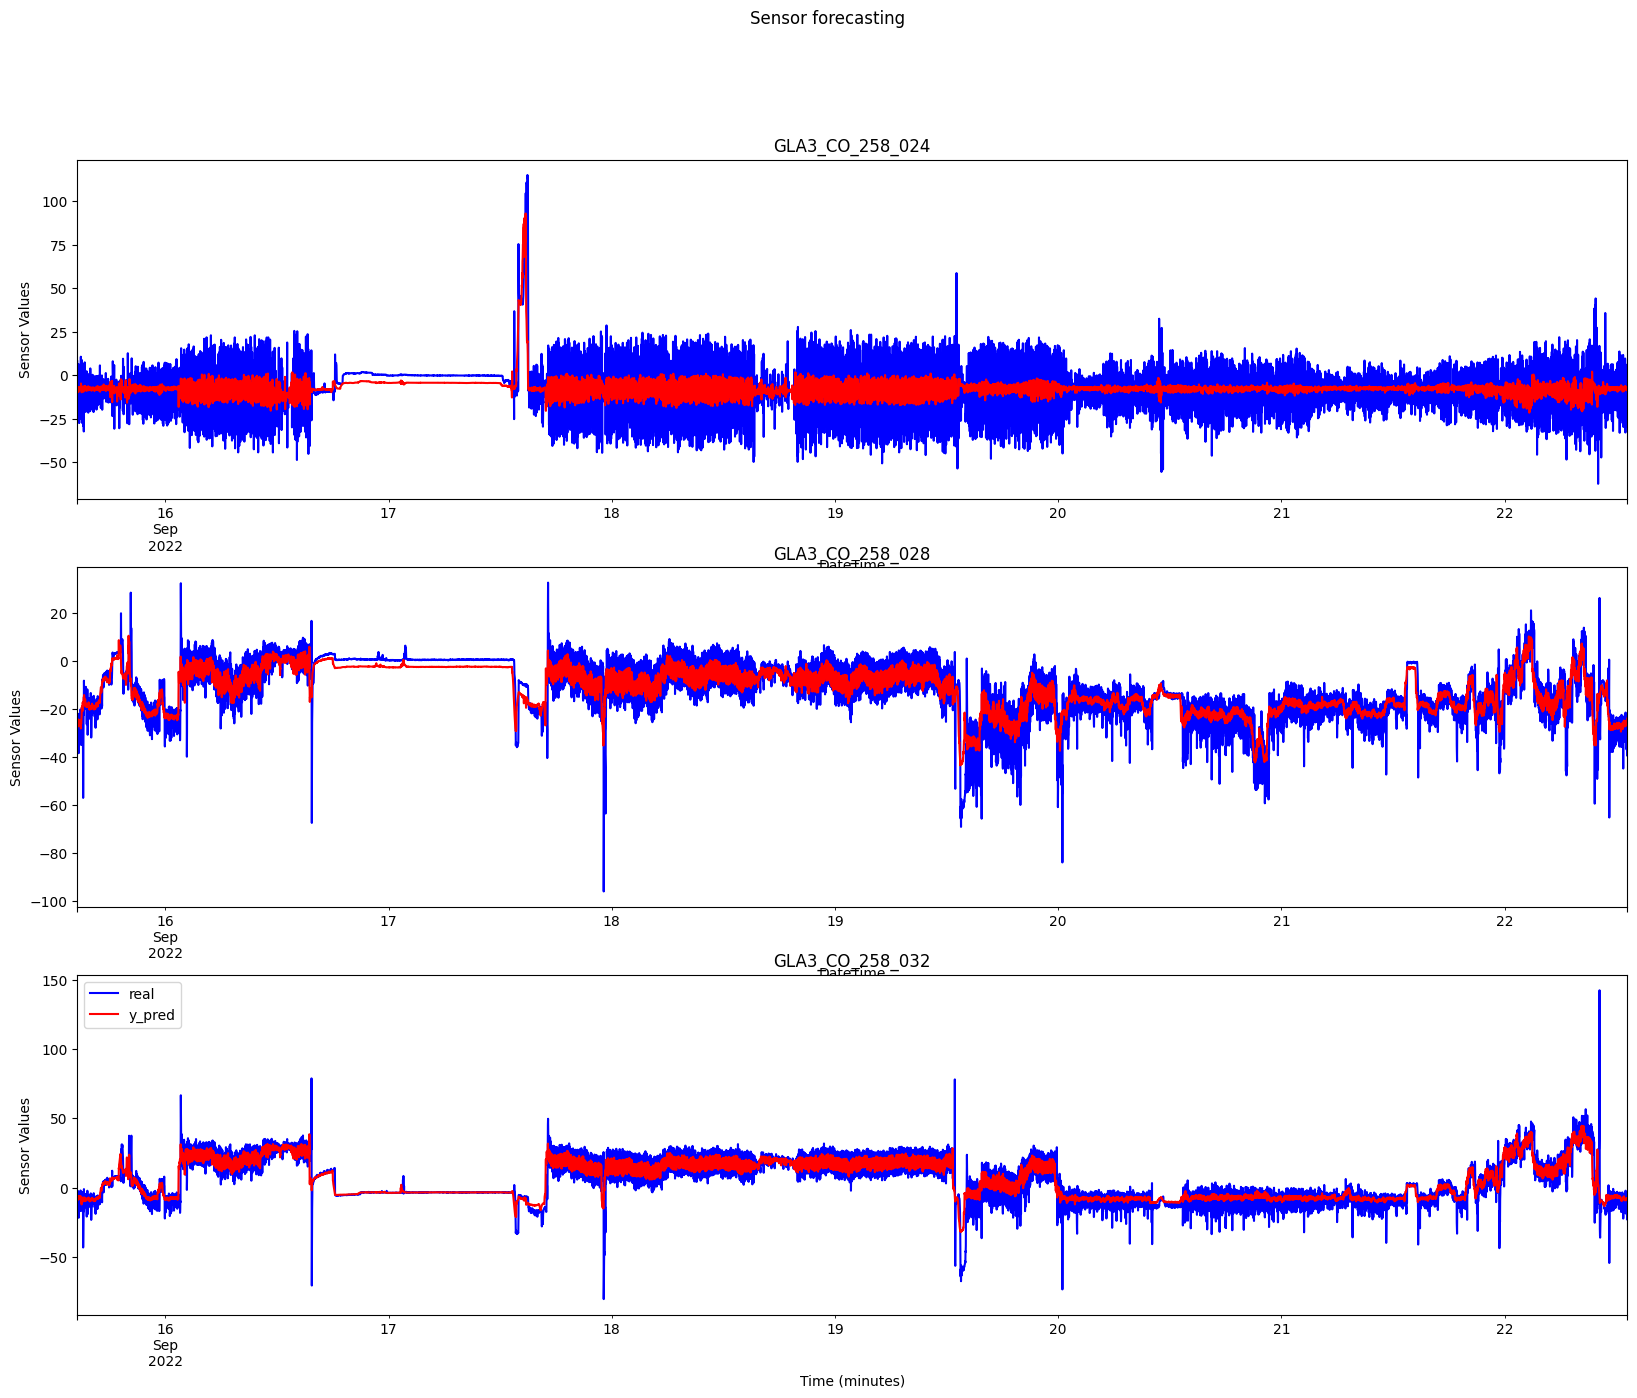

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15))


test_df_inverse['GLA3_CO_258_024'][:10000].plot(ax=ax1, color='blue', label='real')
y_pred_inverse['GLA3_CO_258_024'][:10000].plot(ax=ax1, color='red', label='y_pred')
ax1.set_ylabel('Sensor Values')

test_df_inverse['GLA3_CO_258_028'][:10000].plot(ax=ax2, color='blue', label='real')
y_pred_inverse['GLA3_CO_258_028'][:10000].plot(ax=ax2, color='red', label='y_pred')
ax2.set_ylabel('Sensor Values')

test_df_inverse['GLA3_CO_258_032'][:10000].plot(ax=ax3, color='blue', label='real')
y_pred_inverse['GLA3_CO_258_032'][:10000].plot(ax=ax3, color='red', label='y_pred')
ax3.set_ylabel('Sensor Values')


fig.suptitle('Sensor forecasting')
plt.xlabel('Time (minutes)')
plt.legend()


ax1.set_title('GLA3_CO_258_024')
ax2.set_title('GLA3_CO_258_028')
ax3.set_title('GLA3_CO_258_032')

plt.show()


,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
DateTime,,,
2022-09-15 14:32:00,8.094316,-28.311272,-8.635345
2022-09-15 14:33:00,-11.036061,-34.713183,-16.553342
2022-09-15 14:34:00,-23.431474,-26.074827,-6.416982
2022-09-15 14:35:00,-7.500543,-21.969645,-2.326871
2022-09-15 14:36:00,5.878962,-25.167580,-6.606873
...,...,...,...
2023-01-03 08:10:00,-1.983268,-0.834145,-4.192589
2023-01-03 08:11:00,-2.032998,-0.735439,-4.188824
2023-01-03 08:12:00,-2.009738,-0.793358,-4.195602



Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [10/May/2023 14:27:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/May/2023 14:27:41] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [10/May/2023 14:27:41] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


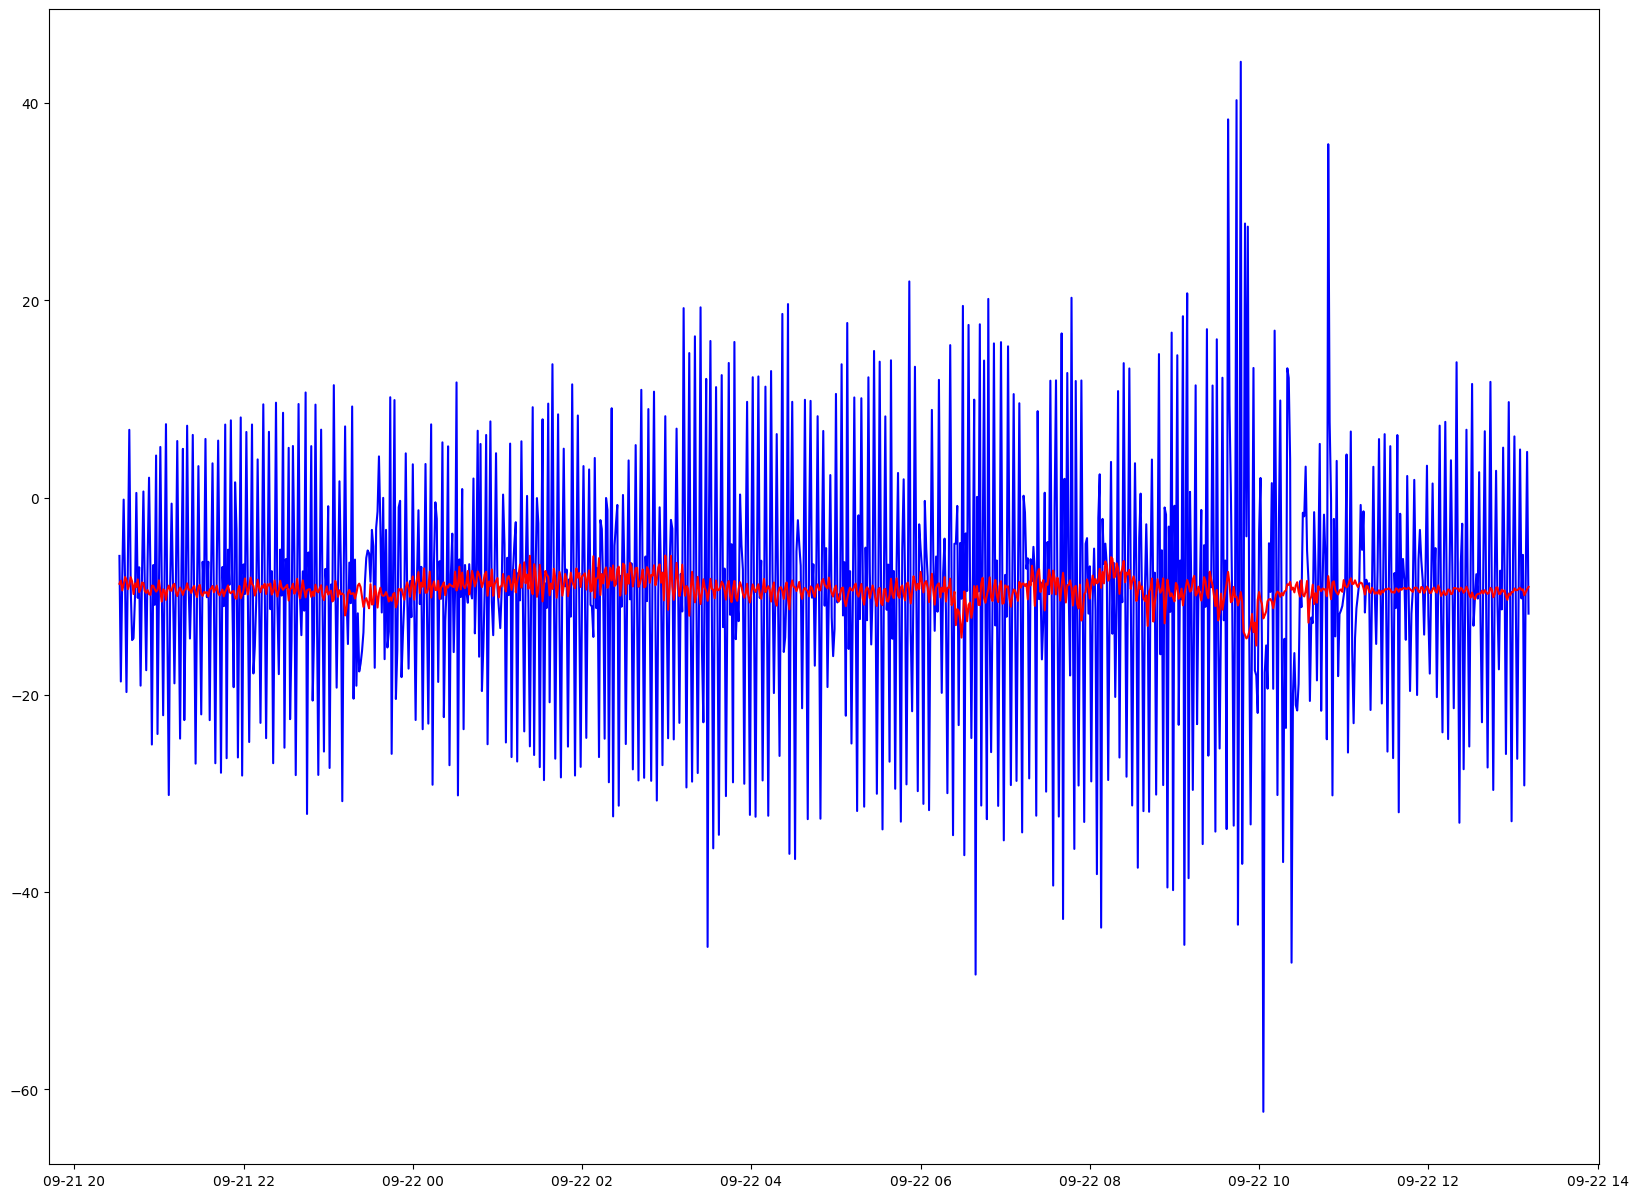

In [31]:
fig, ax = plt.subplots(figsize=(20,15))


ax.plot(test_df_inverse['GLA3_CO_258_024'][9000:10000], color='blue', label='real')
ax.plot(y_pred_inverse['GLA3_CO_258_024'][9000:10000], color='red', label='real')

plugins.connect(fig, plugins.Zoom())

mpld3.show()


In [30]:
def LSTM_evaluation(test_ds, test_df):

    y_pred = model.predict(test_ds)
    y_true_inverse = pd.DataFrame(scaler.inverse_transform(test_df[:len(y_pred)]), columns=test_df.columns, index=test_df[:len(y_pred)].index)
    y_pred_inverse =  pd.DataFrame(scaler.inverse_transform(y_pred), columns=test_df.columns, index=test_df[:len(y_pred)].index)
    result = pd.DataFrame(columns=test_df.columns, index=['MSE', 'MAE', 'MAPE'])

    print(y_true_inverse)
    print(y_pred_inverse)

    for i in range(len(test_df.columns)):
        result.loc['MSE', test_df.columns[i]] = mean_squared_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])
        result.loc['MAE', test_df.columns[i]] = mean_absolute_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])
        result.loc['MAPE', test_df.columns[i]] = mean_absolute_percentage_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])
    
    return result



In [31]:
result = LSTM_evaluation(test_ds, test_df)

4939/4939 [==============================] - 16s 3ms/step
                     GLA3_CO_258_024  GLA3_CO_258_028  GLA3_CO_258_032
DateTime                                                              
2022-09-15 14:32:00         8.094316       -28.311272        -8.635345
2022-09-15 14:33:00       -11.036061       -34.713183       -16.553342
2022-09-15 14:34:00       -23.431474       -26.074827        -6.416982
2022-09-15 14:35:00        -7.500543       -21.969645        -2.326871
2022-09-15 14:36:00         5.878962       -25.167580        -6.606873
...                              ...              ...              ...
2023-01-03 08:10:00        -1.983268        -0.834145        -4.192589
2023-01-03 08:11:00        -2.032998        -0.735439        -4.188824
2023-01-03 08:12:00        -2.009738        -0.793358        -4.195602
2023-01-03 08:13:00        -2.034507        -0.813802        -4.192586
2023-01-03 08:14:00        -1.992440        -0.826384        -4.278162

[158023 rows x 3 c

In [32]:
def mean_absolute_percentage_error2(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [33]:
result

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032
MSE,246.043194,66.698099,107.553462
MAE,10.279316,5.676323,6.22634
MAPE,5787476870915.022461,4503474106563.477539,1308979060995.58252


In [53]:
joined = data_bck[int(n*0.9):].merge(y_pred_inverse, left_index= True, right_index= True, how="right")
joined = joined[['GLA3_CO_258_024_x', 'GLA3_CO_258_024_y', 'trigger']]
joined

,GLA3_CO_258_024_x,GLA3_CO_258_024_y,trigger
DateTime,,,
2022-09-15 14:32:00,0.988782,-8.220104,0
2022-09-15 14:33:00,0.374293,-8.088271,0
2022-09-15 14:34:00,-0.023862,-8.950149,0
2022-09-15 14:35:00,0.487857,-8.936185,0
2022-09-15 14:36:00,0.917622,-7.948170,0
...,...,...,...
2023-01-03 08:10:00,0.665079,-6.631973,0
2023-01-03 08:11:00,0.663481,-6.593624,0
2023-01-03 08:12:00,0.664228,-6.606611,0


In [54]:
df_resampled = joined.resample('15T').agg({'GLA3_CO_258_024_x': 'mean', 'GLA3_CO_258_024_y': 'mean', 'trigger': 'max'})
df_resampled

,GLA3_CO_258_024_x,GLA3_CO_258_024_y,trigger
DateTime,,,
2022-09-15 14:30:00,0.438316,-8.519083,0
2022-09-15 14:45:00,0.441800,-8.394567,0
2022-09-15 15:00:00,0.393409,-8.621736,0
2022-09-15 15:15:00,0.448458,-7.121899,0
2022-09-15 15:30:00,0.443680,-7.940332,0
...,...,...,...
2023-01-03 07:00:00,0.664487,-6.610147,0
2023-01-03 07:15:00,0.663973,-6.604888,0
2023-01-03 07:30:00,0.664653,-6.604047,0


In [59]:
df_resampled['mse'] = np.square(df_resampled['GLA3_CO_258_024_x'] - df_resampled['GLA3_CO_258_024_y'])
df_resampled

,GLA3_CO_258_024_x,GLA3_CO_258_024_y,trigger,mse
DateTime,,,,
2022-09-15 14:30:00,0.438316,-8.519083,0,80.235002
2022-09-15 14:45:00,0.441800,-8.394567,0,78.081391
2022-09-15 15:00:00,0.393409,-8.621736,0,81.272828
2022-09-15 15:15:00,0.448458,-7.121899,0,57.310311
2022-09-15 15:30:00,0.443680,-7.940332,0,70.291665
...,...,...,...,...
2023-01-03 07:00:00,0.664487,-6.610147,0,52.920306
2023-01-03 07:15:00,0.663973,-6.604888,0,52.836333
2023-01-03 07:30:00,0.664653,-6.604047,0,52.833990


In [77]:
example = df_resampled[df_resampled['trigger'] == 1]
example0 = df_resampled[df_resampled['trigger'] == 0]
example0 = example0[example0.mse< example0.quantile(q=0.95).mse]


In [111]:
example0

,GLA3_CO_258_024_x,GLA3_CO_258_024_y,trigger,mse
DateTime,,,,
2022-09-15 14:30:00,0.438316,-8.519083,0,80.235002
2022-09-15 14:45:00,0.441800,-8.394567,0,78.081391
2022-09-15 15:00:00,0.393409,-8.621736,0,81.272828
2022-09-15 15:15:00,0.448458,-7.121899,0,57.310311
2022-09-15 15:30:00,0.443680,-7.940332,0,70.291665
...,...,...,...,...
2023-01-03 07:00:00,0.664487,-6.610147,0,52.920306
2023-01-03 07:15:00,0.663973,-6.604888,0,52.836333
2023-01-03 07:30:00,0.664653,-6.604047,0,52.833990


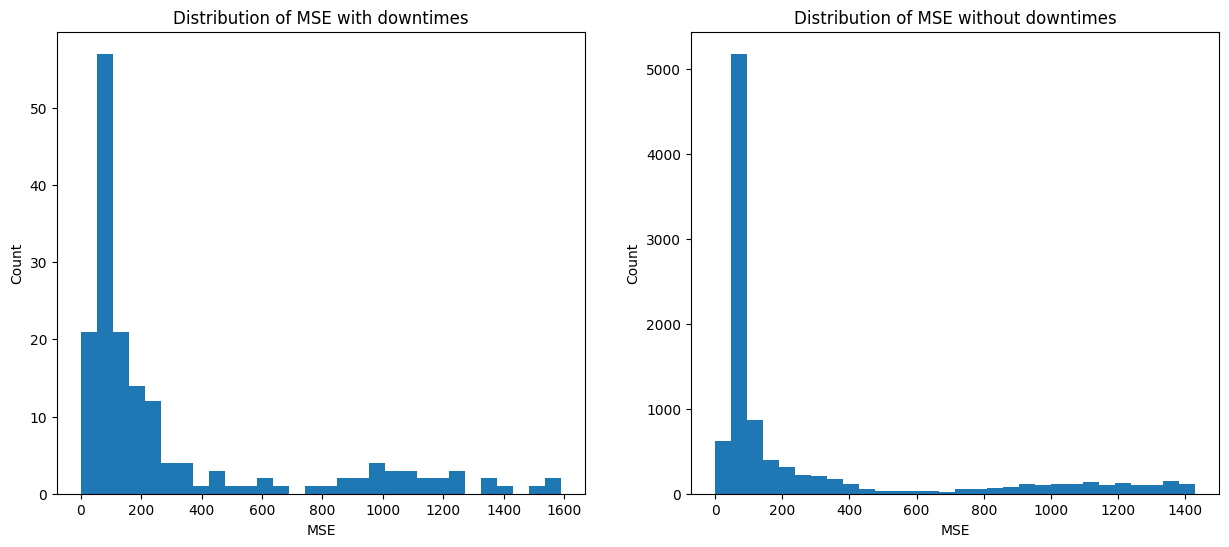

In [80]:
import matplotlib.pyplot as plt

# assuming your dataframe is called `df` and column is named 'mse'
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))
ax1.hist(example['mse'], bins=30)
ax1.set_xlabel('MSE')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of MSE with downtimes')

ax2.hist(example0['mse'], bins=30)
ax2.set_xlabel('MSE')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of MSE without downtimes')


plt.show()

# LSTM Autoencoder

# ARIMA Time series forecasting

In [19]:
df

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger,downtime
DateTime,,,,,
2020-01-01 20:16:00,-65.650317,-0.987418,-0.842734,0.0,0.0
2020-01-01 20:17:00,-65.669952,-0.989482,-0.806054,0.0,0.0
2020-01-01 20:18:00,-65.783628,-0.971396,-0.821555,0.0,0.0
2020-01-01 20:19:00,-65.594260,-0.963901,-0.886142,0.0,0.0
2020-01-01 20:20:00,-65.597874,-0.989221,-0.895180,0.0,0.0
...,...,...,...,...,...
2023-01-03 08:29:00,-2.014161,-0.786678,-4.234787,0.0,1.0
2023-01-03 08:30:00,-2.013133,-0.803941,-4.189848,0.0,1.0
2023-01-03 08:31:00,-2.025463,-0.859015,-4.163954,0.0,1.0


In [23]:
result = adfuller(df['GLA3_CO_258_024'])
p_value = result[1]


KeyboardInterrupt: 

# Machine Learning models

In [23]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger_0.0,trigger_1.0,downtime_0.0,downtime_1.0
2020-01-01 20:16:00,-1.379979,0.957810,0.214982,NaN,NaN,NaN,NaN
2020-01-01 20:17:00,-1.380610,0.957678,0.217594,NaN,NaN,NaN,NaN
2020-01-01 20:18:00,-1.384261,0.958835,0.216490,NaN,NaN,NaN,NaN
2020-01-01 20:19:00,-1.378179,0.959315,0.211890,NaN,NaN,NaN,NaN
2020-01-01 20:20:00,-1.378295,0.957694,0.211246,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1580413,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580414,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580415,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580416,NaN,NaN,NaN,1.0,0.0,0.0,1.0


In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [4]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [5]:
numerical_features = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler

In [7]:
data = df.copy()

In [8]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [9]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['downtime'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [12]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [13]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.9783251967777359


In [14]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.98      0.99   7531904
 no-downtime       0.91      0.99      0.95   1928897

    accuracy                           0.98   9460801
   macro avg       0.95      0.98      0.97   9460801
weighted avg       0.98      0.98      0.98   9460801



In [15]:
results = pd.DataFrame(y_test, y_pred)
results = results.reset_index()
results = results.rename(columns={'index':'y_test', 0:'y_pred'})
results.head()

,y_test,y_pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0


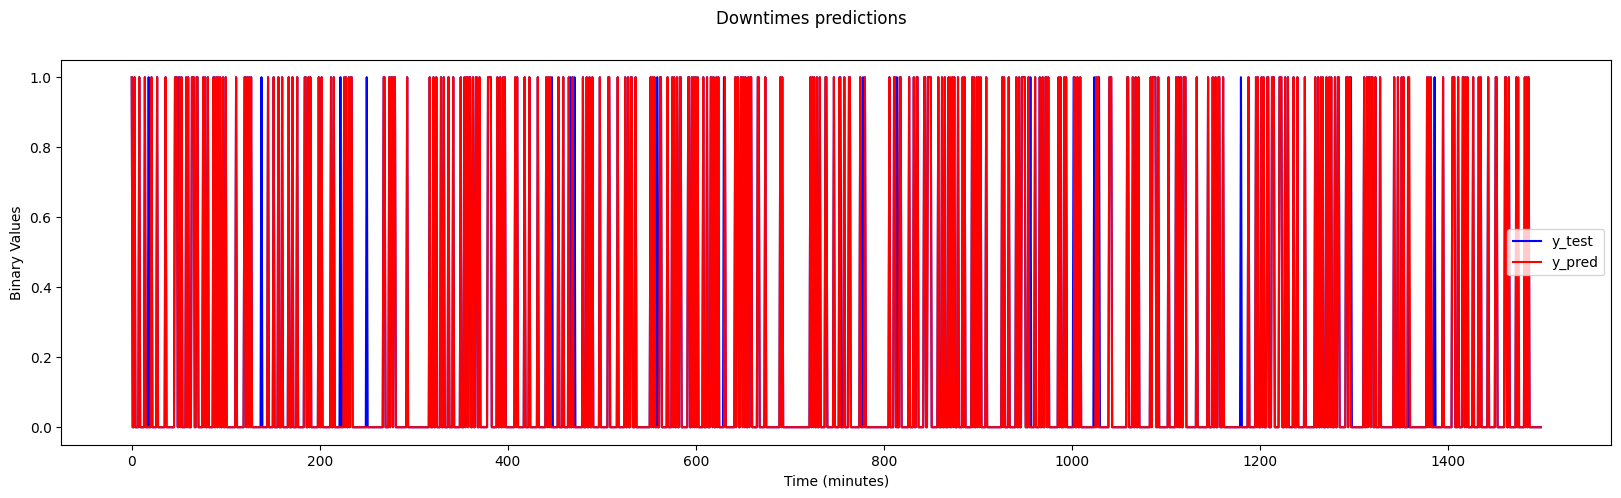

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

# plot the first column on the first subplot
results['y_test'][:1500].plot(ax=ax, color='blue', label='y_test')
results['y_pred'][:1500].plot(ax=ax, color='red', label='y_pred')
ax.set_ylabel('Binary Values')

# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes predictions')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

# LSTM

In [58]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

MemoryError: Unable to allocate 241. MiB for an array with shape (31536001,) and data type object

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
data = df.copy()

In [ ]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)
data = df_minute.copy()

In [ ]:
data.drop(columns=['alarm_11225', 'alarm_11231'], inplace=True)

In [6]:
numerical_features = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
# categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']
categorical_cols = ['downtime']

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [7]:
neg, pos = np.bincount(data['downtime'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
total, pos, 100 * pos / total))

Examples:
    Total: 525601
    Positive: 107584 (20.47% of total)



In [8]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):int(n*0.9)]
test_df = data[int(n*0.9):]

<Axes: xlabel='DateTime'>

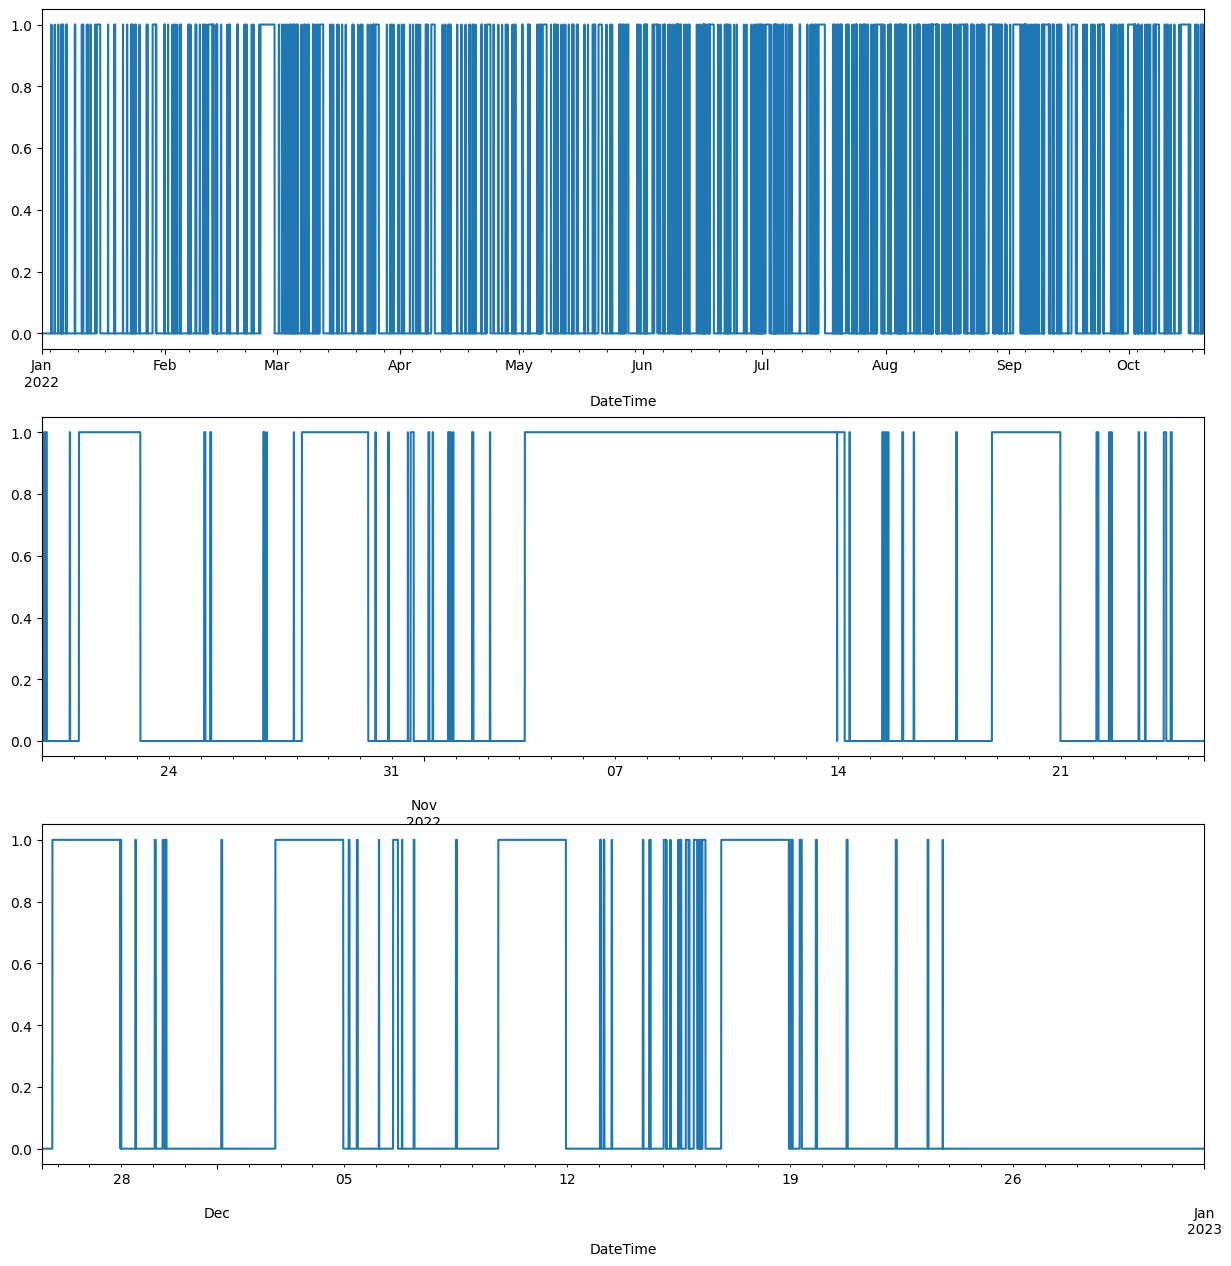

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
train_df['downtime'].plot(ax =ax1)
val_df['downtime'].plot(ax=ax2)
test_df['downtime'].plot(ax=ax3)

In [10]:
window_generator = WindowGenerator(input_width=15, label_width=1, 
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [11]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 15, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [12]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [ ]:

def custom_loss(y_true, y_pred):
    """
    Custom loss function that penalizes misclassifications of the first moment of a downtime event
    """
    # Calculate the binary cross-entropy loss
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # Calculate a weight vector that assigns a higher weight to the first moment of each downtime event
    weight_vector = np.zeros_like(y_true)
    in_downtime = False
    for i, val in enumerate(y_true):
        if val == 1 and not in_downtime:
            weight_vector[i] = 2  # Increase the weight of the first moment of a downtime event
            in_downtime = True
        elif val == 0:
            in_downtime = False

    # Calculate the weighted binary cross-entropy loss
    weighted_bce_loss = K.sum(K.cast(weight_vector, dtype=K.floatx()) * bce_loss) / K.sum(K.cast(weight_vector, dtype=K.floatx()))

    return weighted_bce_loss

In [13]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [38]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    first_1_idx = None
    for i in range(K.int_shape(y_true)[1]):
        if K.any(K.equal(y_true[:,i], 1)):
            first_1_idx = i
            break
    if first_1_idx is None:
        return K.mean(K.binary_crossentropy(y_true, y_pred))
    else:
        y_true_relevant = y_true[:,first_1_idx:]
        y_pred_relevant = y_pred[:,first_1_idx:]
        for i in range(K.int_shape(y_true_relevant)[1]):
            if K.any(K.equal(y_true_relevant[:,i], 0)):
                y_pred_relevant[:,i] = 0
        return K.mean(K.binary_crossentropy(y_true_relevant, y_pred_relevant))



In [39]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

model.compile(loss=custom_loss,
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.BinaryAccuracy()])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [41]:
history = model.fit(train_ds, epochs=6, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/6


ValueError: in user code:

    File "c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\manda\AppData\Local\Temp\ipykernel_22944\1194759263.py", line 6, in custom_loss  *
        if K.any(K.equal(y_true[:,i], 1)):

    ValueError: 'first_1_idx' is None at the end of the else branch.


In [18]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

1641/1641 [==============================] - 20s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     38306
           1       0.97      0.97      0.97     14186

    accuracy                           0.98     52492
   macro avg       0.98      0.98      0.98     52492
weighted avg       0.98      0.98      0.98     52492



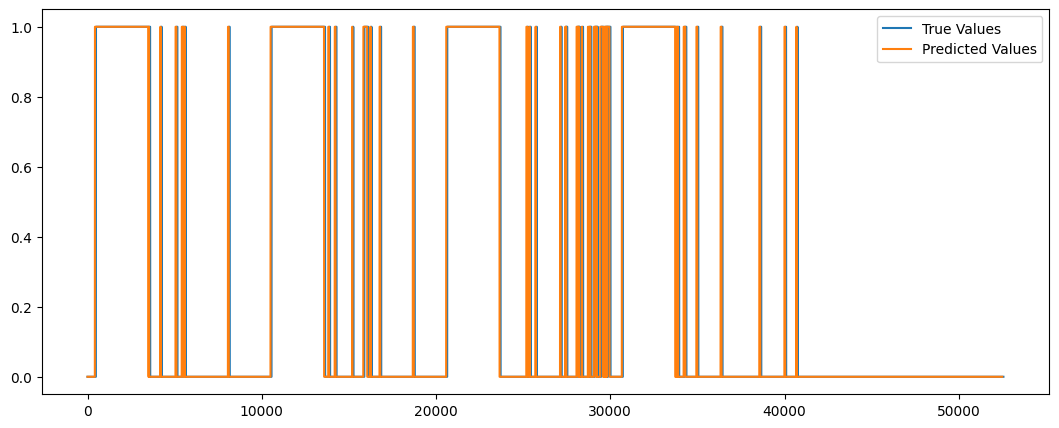

In [19]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

In [20]:
df_2023 = pd.read_csv('./dataframes/data_2023.csv')

In [21]:
df_2023['DateTime'] = pd.to_datetime(df_2023['DateTime'])
df_2023.set_index('DateTime', inplace=True)

<Axes: xlabel='DateTime'>

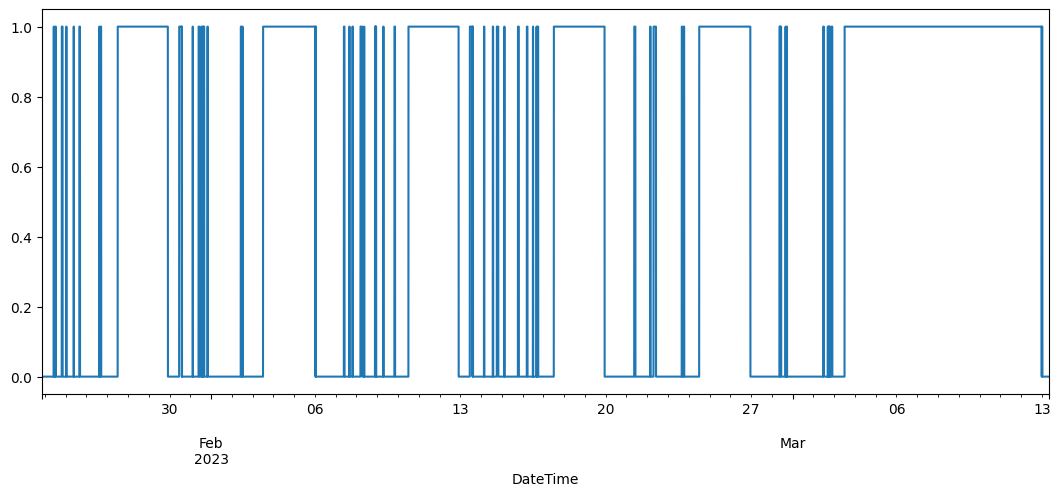

In [22]:
df_2023['downtime'].plot(figsize=(13, 5))

In [23]:
tags = df_2023.iloc[:,0:3].columns.tolist()
alarms = df_2023.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df_2023.columns}
df_minute = df_2023.groupby(pd.Grouper(freq='1T')).agg(agg_dict)
data = df_minute.copy()

<Axes: xlabel='DateTime'>

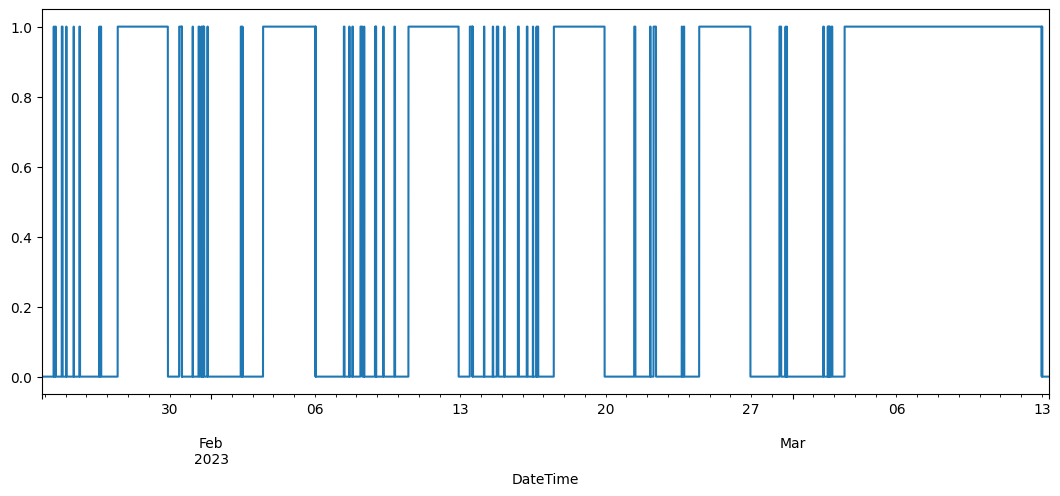

In [24]:
data['downtime'].plot(figsize=(13, 5))

In [25]:
test_ds2 = window_generator.make_dataset(data)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 60, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [26]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds2).round()
y_true = data['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

2181/2181 [==============================] - 32s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.44      0.61     36022
           1       0.62      0.99      0.77     33767

    accuracy                           0.71     69789
   macro avg       0.81      0.72      0.69     69789
weighted avg       0.81      0.71      0.68     69789



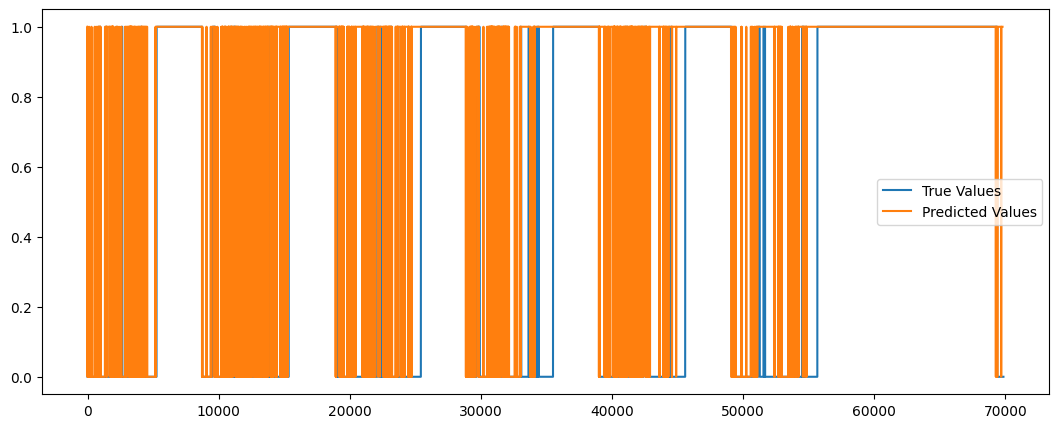

In [27]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(data['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

In [28]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [29]:
test_ds2 = window_generator.make_dataset(data)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 60, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [30]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds2).round()
y_true = data['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

2181/2181 [==============================] - 25s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     36022
           1       0.98      0.98      0.98     33767

    accuracy                           0.98     69789
   macro avg       0.98      0.98      0.98     69789
weighted avg       0.98      0.98      0.98     69789




Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [25/Apr/2023 14:45:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2023 14:45:14] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2023 14:45:14] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


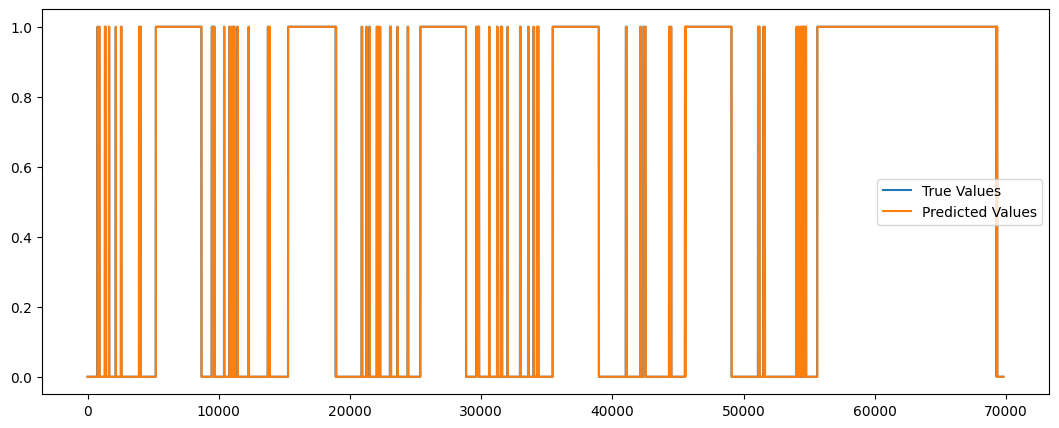

In [31]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(y_true, label='True Values')
ax.plot(y_pred, label='Predicted Values')
ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()

In [32]:
import numpy as np
from scipy.signal import correlate

y_pred_1d = y_pred.flatten()

corr = correlate(y_true, y_pred_1d)

# Find the lag with the maximum correlation
lag = np.argmax(corr) - len(y_true) + 1

print("Lag:", lag)

Lag: -10


# Downtime Trigger classification

## Data processing

In [2]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [4]:
df['trigger'] = (df['downtime'].diff() == 1).astype(int)
df.trigger.value_counts()

0    31535375
1         626
Name: trigger, dtype: int64

In [5]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [6]:
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)

In [17]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(data['GLA3_CO_258_024'][:44000], label='024')
ax.plot(data['GLA3_CO_258_028'][:44000], label='028')
ax.plot(data['GLA3_CO_258_032'][:44000], label='032')
ax.plot(data['downtime'][:44000], label='DOWNTIME')

ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


In [7]:
df_minute.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [8]:
dataframe = df_minute[~((df_minute['downtime'] == 1) & (df_minute['trigger'] == 0))]

In [9]:
dataframe.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

In [10]:
dataframe.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [9]:
df = dataframe.copy()

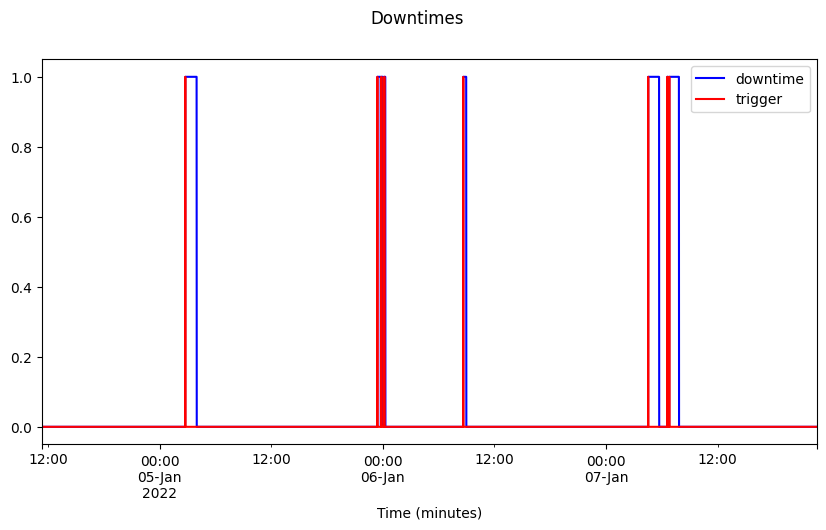

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
df_minute['downtime'][5000:10000].plot(ax =ax, color='blue', label='downtime')
df_minute['trigger'][5000:10000].plot(ax=ax, color='red', label='trigger')


# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

In [10]:
numerical_features = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231', 'trigger']

In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [12]:
data = dataframe.copy()

In [13]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

## ML Model classifier

In [22]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['trigger'].values

In [23]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231,trigger
DateTime,,,,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0,0,0,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0,0,0,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0,0,0,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0,0,0,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0,0,0,0
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0,0,0,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0,0,0,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [27]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_overesampled, y_overresampled = oversample.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [26]:
print(f'X shape is {X_train.shape[0]} and after resampling {X_resampled.shape[0]}')


X shape is 293050 and after resampling 848


In [35]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [36]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.6230283534910385


In [37]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.62      0.77    125391
 no-downtime       0.00      0.67      0.01       202

    accuracy                           0.62    125593
   macro avg       0.50      0.65      0.39    125593
weighted avg       1.00      0.62      0.76    125593



In [34]:
data.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

## LSTM forecaster

In [14]:
df = data.copy()

In [21]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231,downtime
DateTime,,,,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0,0,0,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0,0,0,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0,0,0,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0,0,0,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0,0,0,0
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0,0,0,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0,0,0,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0,0,0,0


In [22]:
df.drop(columns=['downtime', 'alarm_11225', 'alarm_11231'], inplace=True)

KeyError: "['downtime', 'alarm_11225', 'alarm_11231'] not found in axis"

In [23]:
data = df

In [24]:
data.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger
DateTime,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0


In [25]:
data.rename(columns={'trigger':'downtime'}, inplace=True)

In [23]:
data.dtypes

GLA3_CO_258_024    float64
GLA3_CO_258_028    float64
GLA3_CO_258_032    float64
downtime             int64
dtype: object

In [26]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):int(n*0.9)]
test_df = data[int(n*0.9):]

<Axes: xlabel='DateTime'>

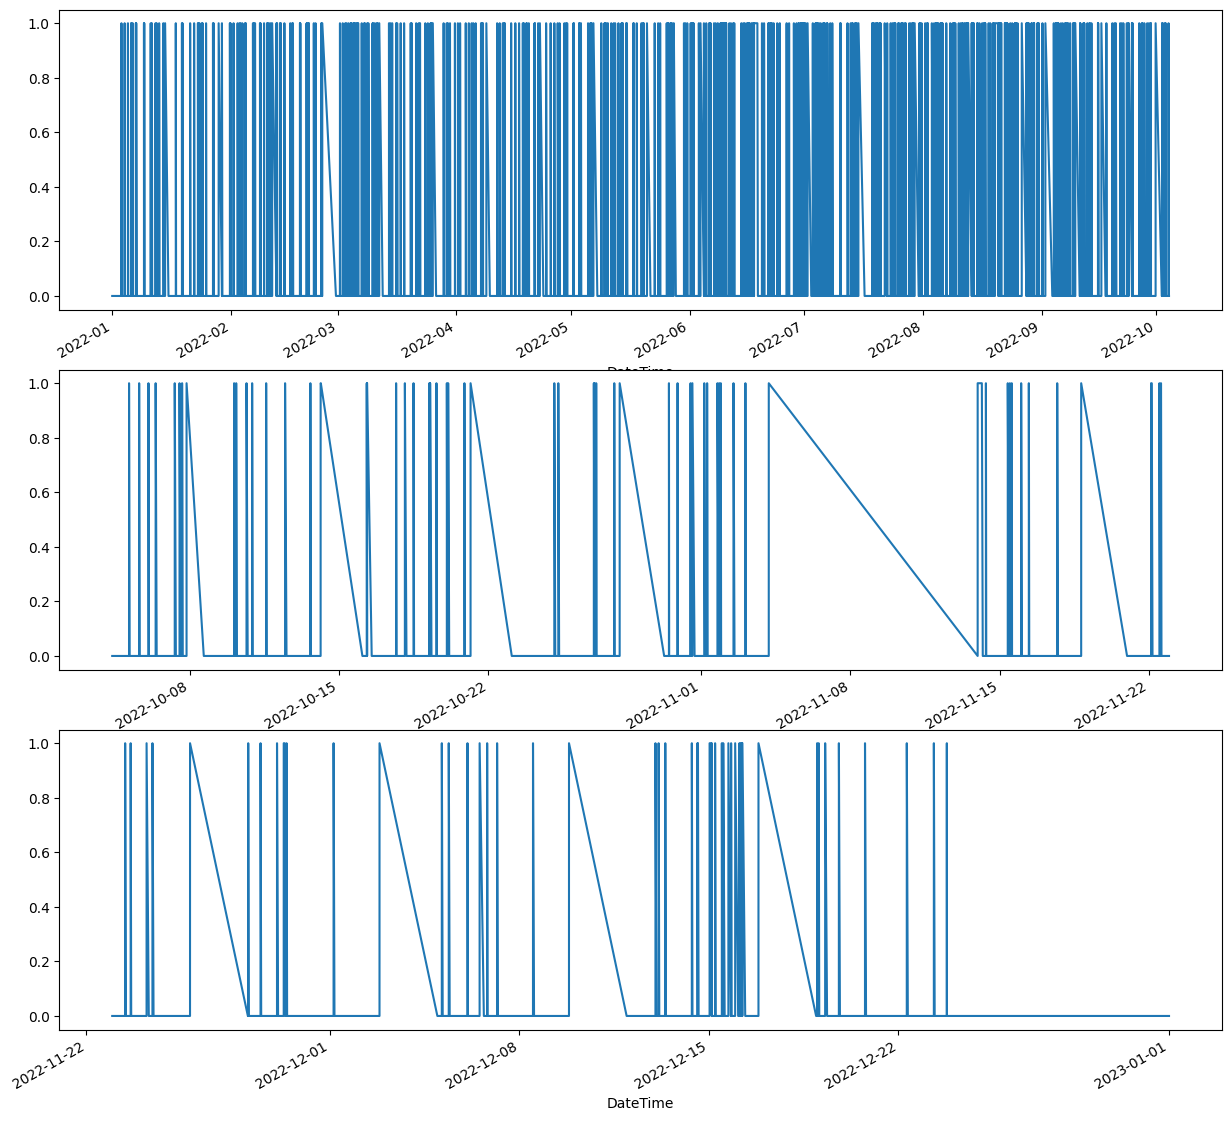

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
train_df['downtime'].plot(ax =ax1)
val_df['downtime'].plot(ax=ax2)
test_df['downtime'].plot(ax=ax3)

In [27]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime
DateTime,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0
...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0


In [28]:

class WindowGenerator2:
    def __init__(self, input_width, label_width, shift, train_df, val_df, 
                 test_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #creates a dictionary with the name of the label column and the position
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #creates a dictionary with the name of the train column and the position

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        #slice(start, end, step)
        self.input_slice = slice(0, input_width) #start in index 0 and take every inp width record
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    def split_windows(self, features):

        print(f'features are {features}')

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]


        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])


        return inputs, labels
    

    def make_dataset(self, data):
        data = np.array(data)
        ds = timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=1,)
        ds = ds.map(self.split_windows)
        print(f'ds is {ds}')

        return ds


In [54]:
window_generator = WindowGenerator(input_width=5, label_width=1, 
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [55]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [56]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [94]:
class_weight = {0: 1, 1: 450}

In [95]:
def weighted_binary_crossentropy(class_weight):
    def loss(y_true, y_pred):
        # calculate the weighted binary cross-entropy loss
        b_ce = K.binary_crossentropy(y_true, y_pred, from_logits=True)
        weight_vector = y_true * class_weight[1] + (1. - y_true) * class_weight[0]
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return loss

In [96]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [97]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

# model.compile(loss=custom_loss(cost_matrix),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

model.compile(loss=weighted_binary_crossentropy(class_weight), 
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [98]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [99]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>

In [100]:
import tensorflow.keras.backend as K

In [101]:
history = model.fit(train_ds, epochs=4, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/4


c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10466/10466 [==============================] - 55s 5ms/step - loss: 1.1563 - accuracy: 0.9242 - val_loss: 1.1509 - val_accuracy: 0.8851
Epoch 2/4
10466/10466 [==============================] - 52s 5ms/step - loss: 1.1431 - accuracy: 0.9307 - val_loss: 1.1496 - val_accuracy: 0.9120
Epoch 3/4
10466/10466 [==============================] - 53s 5ms/step - loss: 1.1407 - accuracy: 0.9292 - val_loss: 1.1488 - val_accuracy: 0.9158
Epoch 4/4
10466/10466 [==============================] - 53s 5ms/step - loss: 1.1371 - accuracy: 0.9226 - val_loss: 1.1468 - val_accuracy: 0.9172


In [102]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

1308/1308 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     41806
           1       0.00      0.04      0.00        50

    accuracy                           0.95     41856
   macro avg       0.50      0.50      0.49     41856
weighted avg       1.00      0.95      0.98     41856



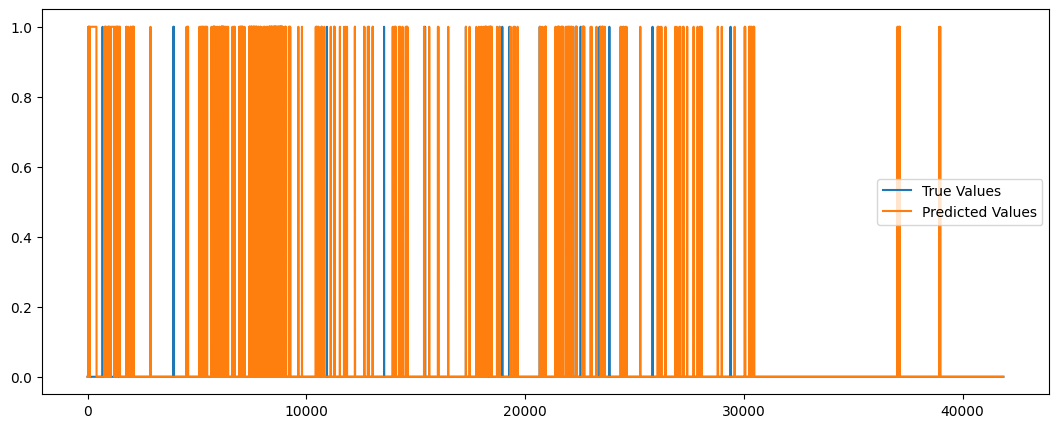

In [103]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

# ML with alarms

In [12]:
data = pd.read_csv('./dataframes/pivot_alarms_cleaned.csv')

In [13]:
data.head()

,DateTime,2421,2445,4203,6280,6336,7167,9218,9219,9495,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
0,2022-01-03 09:53:36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2022-01-03 10:31:02,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-03 10:55:39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2022-01-03 10:59:57,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-03 11:23:14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [15]:
df_minute = data.groupby(pd.Grouper(freq='1T')).agg('max')

In [16]:
print(f"seconds {data.shape} and after {df_minute.shape}")

seconds (81110, 30) and after (566766, 30)
